In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import utils.functions as f

# Direct Dataset

In [3]:
dataset = "direct_matching_20240213"
df_processed = pd.read_csv(f"Data/{dataset}_processed.csv", sep=";")

## Gender

In [4]:
sectors = sorted(df_processed.job_sector.unique())
protected_attribute = "cand_gender"

df_mitigation = df_processed.drop(columns=["distance_km", "match_score", "match_rank", "cand_id", "cand_education", "job_professional_category"]).copy()
columns = df_mitigation.columns
columns = columns.drop(["job_id","job_sector"])

results_df_gender = f.compute_bias_differences(df_mitigation,sectors,protected_attribute,columns)
results_df_gender.to_excel('Results/Mitigation_direct/results_df_gender_direct.xlsx', index=False)
results_df_gender

d:\università\Magistrale\AI_industry\AEQUITAS-Debiasing-main\utils\functions.py:792: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, differences_df], ignore_index=True)


,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,job_contract_type,job_work_province,Svedese,Spagnolo,Finlandese,Ebraico,...,Cinese,Arabo,Serbo,Albanese,Croato,Ceco,Danese,Rumeno,Macedone,Tedesco
0,0.0,0.0,184.0,11.0,0.0,185.0,0.0,0.0,0.0,0.0,...,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,106.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,585.0,128.0,0.0,50.0,0.0,0.0,0.0,0.0,...,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,223.0,180.0,0.0,85.0,3.0,0.0,0.0,0.0,...,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,953.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,464.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,484.0,159.0,0.0,180.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,1721.0,1260.0,0.0,412.0,0.0,0.0,2.0,0.0,...,0.0,10.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
8,0.0,0.0,955.0,248.0,0.0,780.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,346.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0


In [5]:
%matplotlib inline

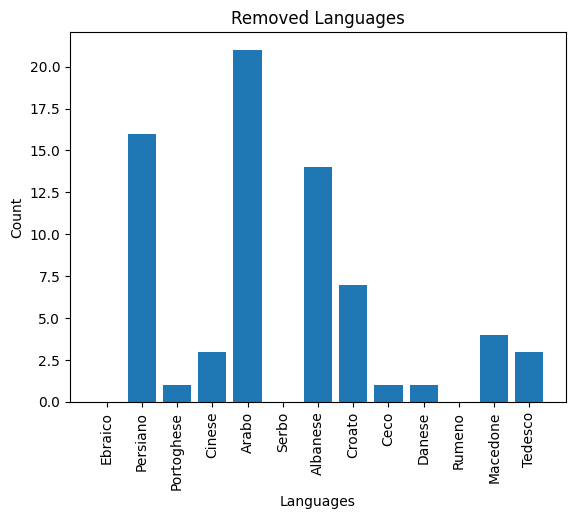

In [6]:
sums_gender = results_df_gender.iloc[:, 9:].sum()

f.plot_series(sums_gender,'Removed Languages','Languages')

In [7]:
job_df_orig_gender, job_df_repaired_gender = f.compute_repaired_df(df_mitigation,7,protected_attribute)

In [8]:
with open('utils/encodings/direct_matching_20240213_cand_domicile_region_encoding.json', 'r') as file:
    region_mapping = json.load(file)
with open('utils/encodings/direct_matching_20240213_provinces_encoding.json', 'r') as file:
    province_mapping = json.load(file)

reversed_region_mapping = {v: k for k, v in region_mapping.items()}
reversed_province_mapping = {v: k for k, v in province_mapping.items()}

job_df_orig_gender['cand_domicile_region_str'] = job_df_orig_gender['cand_domicile_region'].map(reversed_region_mapping)
job_df_repaired_gender['cand_domicile_region_str'] = job_df_repaired_gender['cand_domicile_region'].map(reversed_region_mapping)

job_df_orig_gender['cand_domicile_province_str'] = job_df_orig_gender['cand_domicile_province'].map(reversed_province_mapping)
job_df_repaired_gender['cand_domicile_province_str'] = job_df_repaired_gender['cand_domicile_province'].map(reversed_province_mapping)

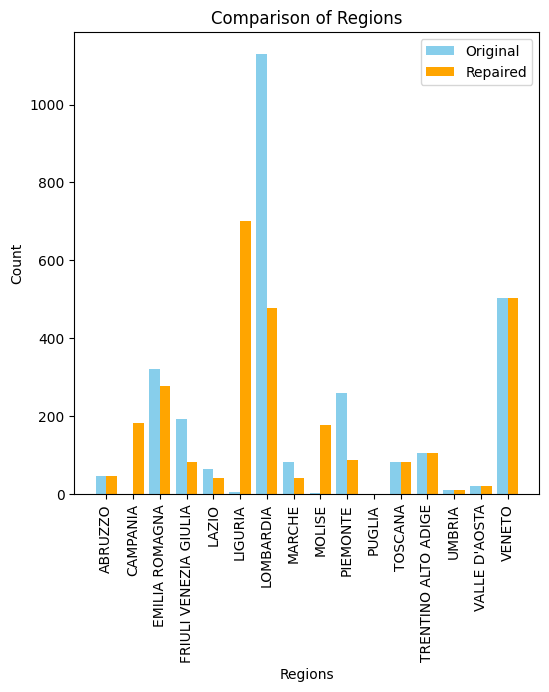

In [9]:
orig_counts = job_df_orig_gender['cand_domicile_region_str'].value_counts()
repaired_counts = job_df_repaired_gender['cand_domicile_region_str'].value_counts()

orig_counts,repaired_counts,all_index = f.prepare_different_series(orig_counts,repaired_counts)
f.compare_plot(orig_counts,repaired_counts,all_index,'Comparison of Regions','Regions')

## Age

In [10]:
protected_attribute_age = "cand_age_bucket"

results_df_age = f.compute_bias_differences(df_mitigation,sectors,protected_attribute_age,columns)
results_df_age.to_excel('Results/Mitigation_direct/results_df_age_direct.xlsx', index=False)
results_df_age

d:\università\Magistrale\AI_industry\AEQUITAS-Debiasing-main\utils\functions.py:792: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, differences_df], ignore_index=True)


,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,job_contract_type,job_work_province,Svedese,Spagnolo,Finlandese,Ebraico,...,Cinese,Arabo,Serbo,Albanese,Croato,Ceco,Danese,Rumeno,Macedone,Tedesco
0,0.0,0.0,335.0,73.0,0.0,-68.0,0.0,0.0,0.0,0.0,...,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,8.0
1,0.0,0.0,356.0,11.0,0.0,-220.0,0.0,5.0,0.0,8.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0
2,0.0,0.0,15.0,548.0,0.0,1986.0,0.0,0.0,0.0,0.0,...,1.0,2.0,0.0,1.0,10.0,0.0,0.0,0.0,0.0,17.0
3,0.0,0.0,70.0,185.0,0.0,444.0,3.0,0.0,0.0,0.0,...,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.0
4,0.0,0.0,402.0,856.0,0.0,404.0,2.0,0.0,0.0,0.0,...,0.0,3.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,5.0
5,0.0,0.0,253.0,440.0,0.0,850.0,0.0,0.0,0.0,0.0,...,0.0,28.0,0.0,5.0,8.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,189.0,264.0,0.0,171.0,0.0,0.0,0.0,14.0,...,0.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,4.0
7,0.0,0.0,403.0,537.0,0.0,-117.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,6.0,0.0,1.0,0.0,0.0,2.0,8.0
8,0.0,0.0,134.0,175.0,0.0,485.0,2.0,28.0,1.0,0.0,...,0.0,9.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,7.0
9,0.0,0.0,66.0,342.0,0.0,823.0,0.0,11.0,0.0,16.0,...,0.0,1.0,0.0,0.0,4.0,0.0,0.0,43.0,0.0,3.0


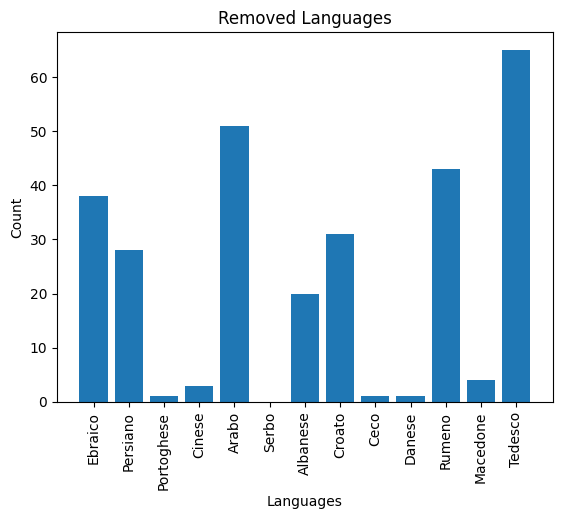

In [11]:
sums_age = results_df_age.iloc[:, 9:].sum()

f.plot_series(sums_age,'Removed Languages','Languages')

In [12]:
job_df_orig_age, job_df_repaired_age = f.compute_repaired_df(df_mitigation,2,protected_attribute_age)
job_df_orig_age['job_work_province_str'] = job_df_orig_age['job_work_province'].map(reversed_province_mapping)
job_df_repaired_age['job_work_province_str'] = job_df_repaired_age['job_work_province'].map(reversed_province_mapping)

job_df_orig_age['cand_domicile_region_str'] = job_df_orig_age['cand_domicile_region'].map(reversed_region_mapping)
job_df_repaired_age['cand_domicile_region_str'] = job_df_repaired_age['cand_domicile_region'].map(reversed_region_mapping)

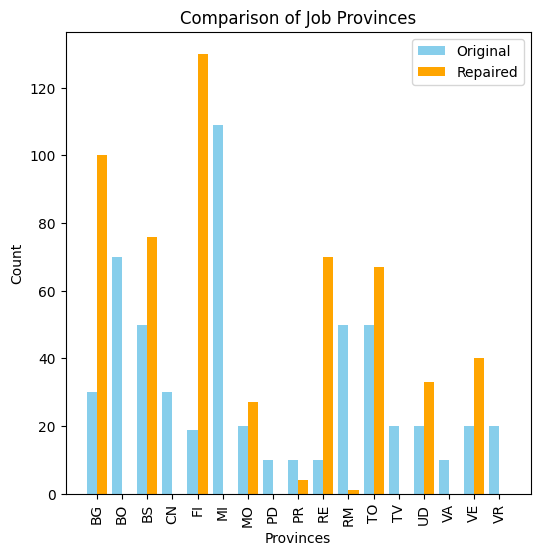

In [13]:
orig_counts = job_df_orig_age['job_work_province_str'].value_counts()
repaired_counts = job_df_repaired_age['job_work_province_str'].value_counts()

orig_counts,repaired_counts,all_index = f.prepare_different_series(orig_counts,repaired_counts)
f.compare_plot(orig_counts,repaired_counts,all_index,'Comparison of Job Provinces','Provinces')

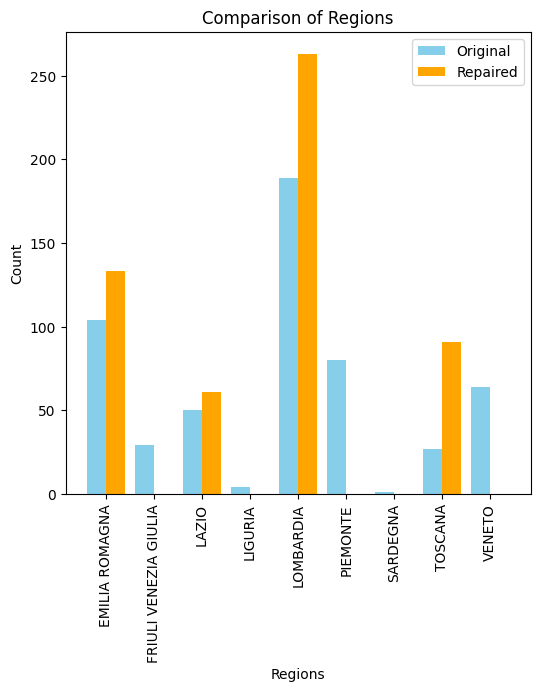

In [14]:
orig_counts = job_df_orig_age['cand_domicile_region_str'].value_counts()
repaired_counts = job_df_repaired_age['cand_domicile_region_str'].value_counts()

orig_counts,repaired_counts,all_index = f.prepare_different_series(orig_counts,repaired_counts)
f.compare_plot(orig_counts,repaired_counts,all_index,'Comparison of Regions','Regions')

## Location

In [15]:
protected_attribute_location = "same_location"
results_df_location = f.compute_bias_differences(df_mitigation,sectors,protected_attribute_location,columns)
results_df_location.to_excel('Results/Mitigation_direct/results_df_location_direct.xlsx', index=False)
results_df_location

d:\università\Magistrale\AI_industry\AEQUITAS-Debiasing-main\utils\functions.py:792: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, differences_df], ignore_index=True)


,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,job_contract_type,job_work_province,Svedese,Spagnolo,Finlandese,Ebraico,...,Arabo,Serbo,Albanese,Croato,Ceco,Danese,Rumeno,Macedone,Tedesco,same_location
0,0.0,0.0,1440.0,427.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,231.0,247.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0
2,0.0,0.0,2249.0,34.0,0.0,56.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,611.0,349.0,0.0,297.0,3.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1214.0,918.0,0.0,1149.0,2.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0
5,0.0,0.0,3772.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,510.0,305.0,0.0,360.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,2880.0,1800.0,0.0,1195.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,1825.0,310.0,0.0,776.0,2.0,0.0,1.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,864.0,354.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


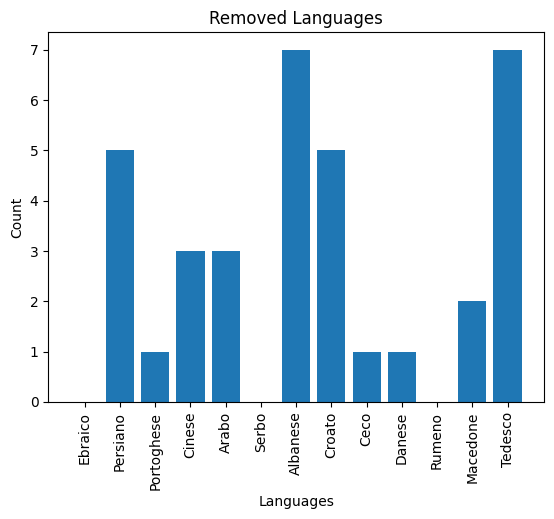

In [16]:
sums_location = results_df_location.iloc[:, 9:-1].sum()

f.plot_series(sums_location,'Removed Languages','Languages')

In [17]:
job_df_orig_location, job_df_repaired_location = f.compute_repaired_df(df_mitigation,7,protected_attribute_location)
job_df_orig_location['job_work_province_str'] = job_df_orig_location['job_work_province'].map(reversed_province_mapping)
job_df_repaired_location['job_work_province_str'] = job_df_repaired_location['job_work_province'].map(reversed_province_mapping)

job_df_orig_location['cand_domicile_province_str'] = job_df_orig_location['cand_domicile_province'].map(reversed_province_mapping)
job_df_repaired_location['cand_domicile_province_str'] = job_df_repaired_location['cand_domicile_province'].map(reversed_province_mapping)

job_df_orig_location['cand_domicile_region_str'] = job_df_orig_location['cand_domicile_region'].map(reversed_region_mapping)
job_df_repaired_location['cand_domicile_region_str'] = job_df_repaired_location['cand_domicile_region'].map(reversed_region_mapping)

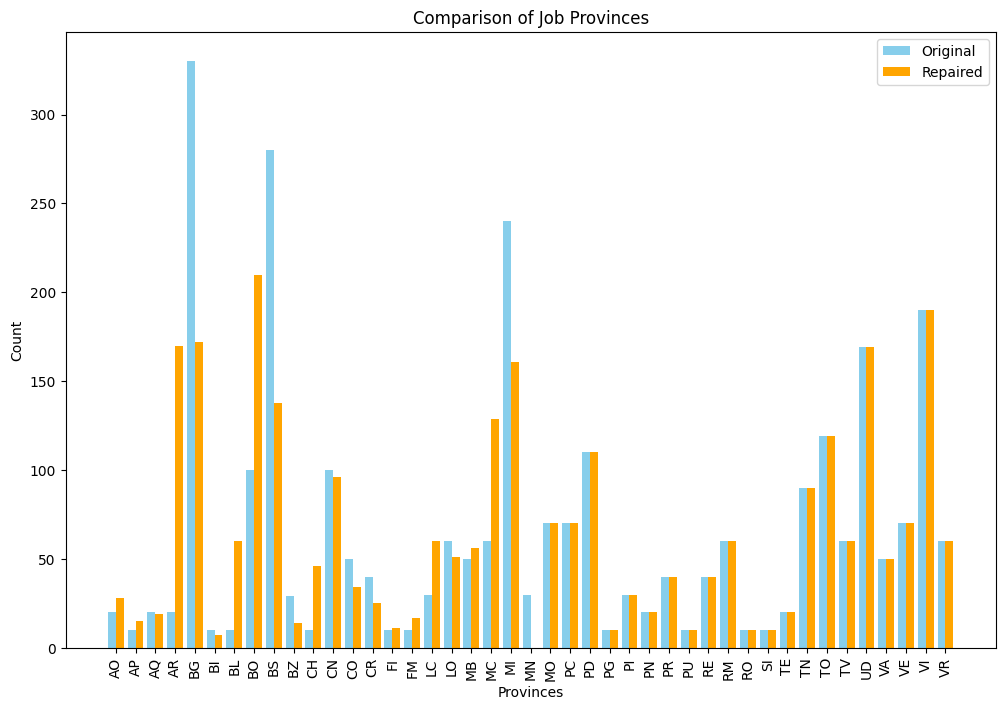

In [18]:
orig_counts = job_df_orig_location['job_work_province_str'].value_counts()
repaired_counts = job_df_repaired_location['job_work_province_str'].value_counts()

orig_counts,repaired_counts,all_index = f.prepare_different_series(orig_counts,repaired_counts)
f.compare_plot(orig_counts,repaired_counts,all_index,'Comparison of Job Provinces','Provinces',size=(12,8))

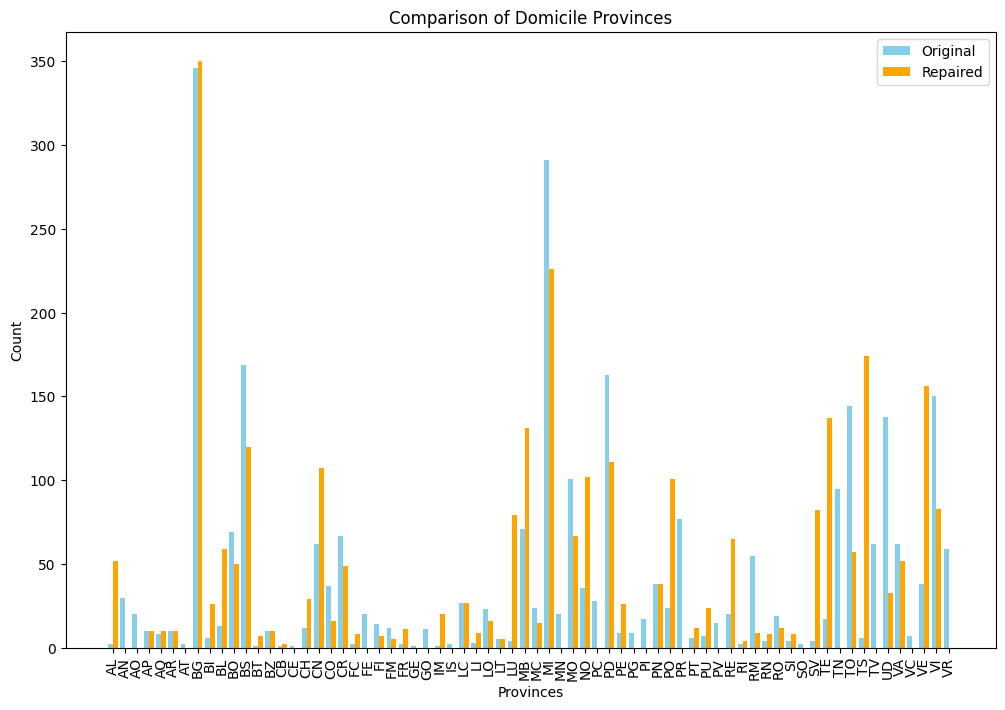

In [19]:
orig_counts = job_df_orig_location['cand_domicile_province_str'].value_counts()
repaired_counts = job_df_repaired_location['cand_domicile_province_str'].value_counts()

orig_counts,repaired_counts,all_index = f.prepare_different_series(orig_counts,repaired_counts)
f.compare_plot(orig_counts,repaired_counts,all_index,'Comparison of Domicile Provinces','Provinces',size=(12,8))

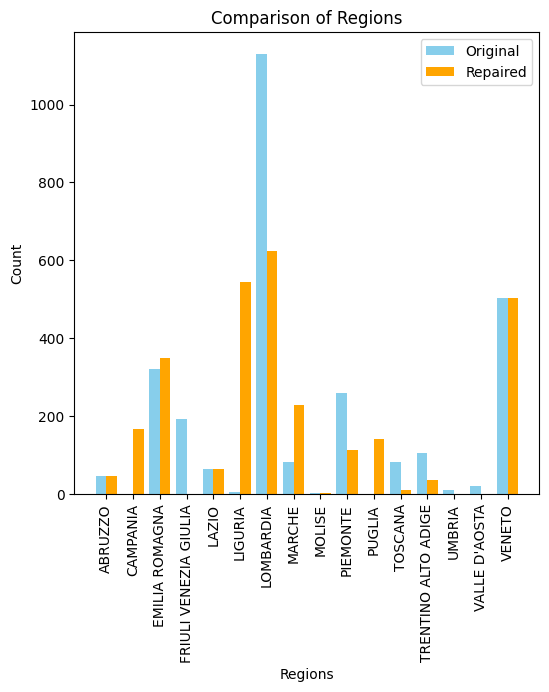

In [20]:
orig_counts = job_df_orig_location['cand_domicile_region_str'].value_counts()
repaired_counts = job_df_repaired_location['cand_domicile_region_str'].value_counts()

orig_counts,repaired_counts,all_index = f.prepare_different_series(orig_counts,repaired_counts)
f.compare_plot(orig_counts,repaired_counts,all_index,'Comparison of Regions','Regions')

# Reverse Dataset


In [21]:
dataset = "reverse_matching_20240213"
df_processed = pd.read_csv(f"Data/{dataset}_processed.csv", sep=";")
df_mitigation = df_processed.drop(columns=["distance_km", "match_score", "match_rank", "cand_id", "cand_education", "job_professional_category"]).copy()
columns = df_mitigation.columns
columns = columns.drop(["job_id","job_sector"])
sectors = sorted(df_processed.job_sector.unique())

## Gender

In [22]:
protected_attribute = "cand_gender"

results_df_gender = f.compute_bias_differences(df_mitigation,sectors,protected_attribute,columns)
results_df_gender.to_excel('Results/Mitigation_reverse/results_df_gender_reverse.xlsx', index=False)
results_df_gender

d:\università\Magistrale\AI_industry\AEQUITAS-Debiasing-main\utils\functions.py:792: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, differences_df], ignore_index=True)


,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,job_contract_type,job_work_province,Norvegese,Catalano,Macedone,Portoghese,...,Finlandese,Albanese,Danese,Ebraico,Spagnolo,Serbo,Greco,Cinese,Bulgaro,Rumeno
0,0.0,0.0,8171.0,0.0,0.0,8552.0,5.0,1.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1174.0,262.0,0.0,0.0,0.0,0.0,3.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1515.0,490.0,0.0,0.0,8.0,0.0,0.0,5.0,...,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,3252.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,3524.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,...,0.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,7.0,0.0
5,0.0,0.0,926.0,370.0,0.0,887.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0
6,0.0,0.0,1388.0,529.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,0.0,0.0,6025.0,0.0,0.0,0.0,4.0,0.0,0.0,8.0,...,1.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0
8,0.0,0.0,13571.0,6242.0,0.0,2034.0,6.0,5.0,3.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
9,0.0,0.0,10500.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0,...,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


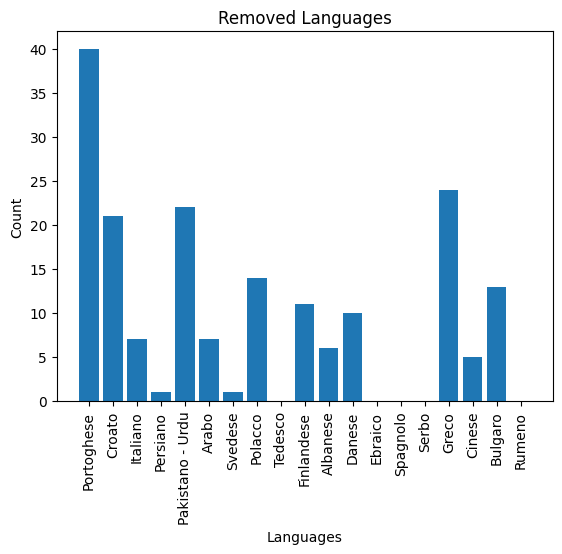

In [23]:
sums_gender = results_df_gender.iloc[:, 9:].sum()

f.plot_series(sums_gender,'Removed Languages','Languages')

In [24]:
job_df_orig_gender, job_df_repaired_gender = f.compute_repaired_df(df_mitigation,8,protected_attribute)

In [25]:
with open('utils/encodings/reverse_matching_20240213_cand_domicile_region_encoding.json', 'r') as file:
    region_mapping = json.load(file)
with open('utils/encodings/reverse_matching_20240213_provinces_encoding.json', 'r') as file:
    province_mapping = json.load(file)

reversed_region_mapping = {v: k for k, v in region_mapping.items()}
reversed_province_mapping = {v: k for k, v in province_mapping.items()}

job_df_orig_gender['cand_domicile_region_str'] = job_df_orig_gender['cand_domicile_region'].map(reversed_region_mapping)
job_df_repaired_gender['cand_domicile_region_str'] = job_df_repaired_gender['cand_domicile_region'].map(reversed_region_mapping)

job_df_orig_gender['cand_domicile_province_str'] = job_df_orig_gender['cand_domicile_province'].map(reversed_province_mapping)
job_df_repaired_gender['cand_domicile_province_str'] = job_df_repaired_gender['cand_domicile_province'].map(reversed_province_mapping)

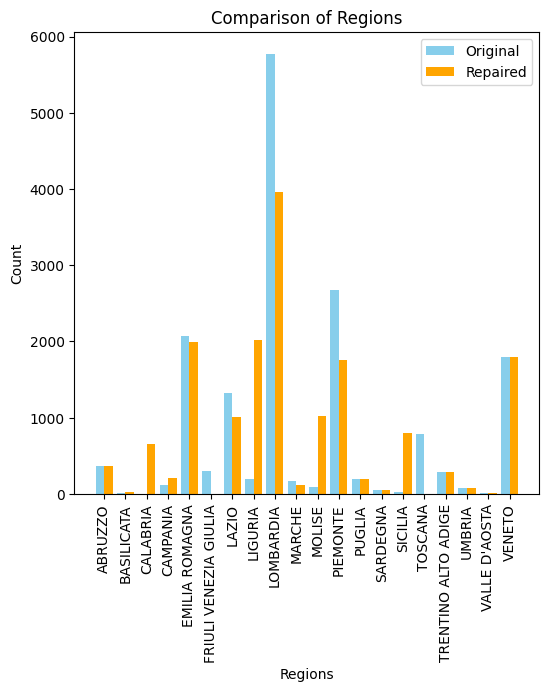

In [26]:
orig_counts = job_df_orig_gender['cand_domicile_region_str'].value_counts()
repaired_counts = job_df_repaired_gender['cand_domicile_region_str'].value_counts()

orig_counts,repaired_counts,all_index = f.prepare_different_series(orig_counts,repaired_counts)
f.compare_plot(orig_counts,repaired_counts,all_index,'Comparison of Regions','Regions')

## Age

In [27]:
protected_attribute_age = "cand_age_bucket"

results_df_age = f.compute_bias_differences(df_mitigation,sectors,protected_attribute_age,columns)
results_df_age.to_excel('Results/Mitigation_reverse/results_df_age_reverse.xlsx', index=False)
results_df_age

d:\università\Magistrale\AI_industry\AEQUITAS-Debiasing-main\utils\functions.py:792: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, differences_df], ignore_index=True)


,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,job_contract_type,job_work_province,Norvegese,Catalano,Macedone,Portoghese,...,Finlandese,Albanese,Danese,Ebraico,Spagnolo,Serbo,Greco,Cinese,Bulgaro,Rumeno
0,0.0,0.0,290.0,1857.0,51.0,2605.0,5.0,1.0,8.0,9.0,...,0.0,31.0,0.0,0.0,0.0,0.0,0.0,34.0,12.0,0.0
1,0.0,0.0,1037.0,488.0,0.0,1329.0,0.0,0.0,3.0,0.0,...,1.0,3.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1858.0,769.0,0.0,2272.0,8.0,0.0,0.0,5.0,...,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0
3,0.0,0.0,798.0,1460.0,9.0,24.0,0.0,3.0,4.0,0.0,...,0.0,26.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0
4,0.0,0.0,4112.0,2085.0,0.0,462.0,5.0,8.0,23.0,1.0,...,3.0,22.0,5.0,0.0,0.0,0.0,3.0,63.0,7.0,0.0
5,0.0,0.0,165.0,356.0,0.0,316.0,0.0,0.0,1.0,1.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0
6,0.0,0.0,854.0,338.0,10.0,1101.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,0.0,0.0,-75.0,-2809.0,0.0,-1065.0,4.0,5.0,16.0,8.0,...,1.0,0.0,0.0,0.0,0.0,0.0,6.0,26.0,9.0,0.0
8,0.0,0.0,5138.0,-3058.0,8.0,5267.0,6.0,5.0,3.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,23.0,24.0,0.0
9,0.0,0.0,26.0,-2507.0,0.0,4572.0,2.0,2.0,2.0,1.0,...,5.0,0.0,5.0,0.0,0.0,0.0,1.0,57.0,7.0,0.0


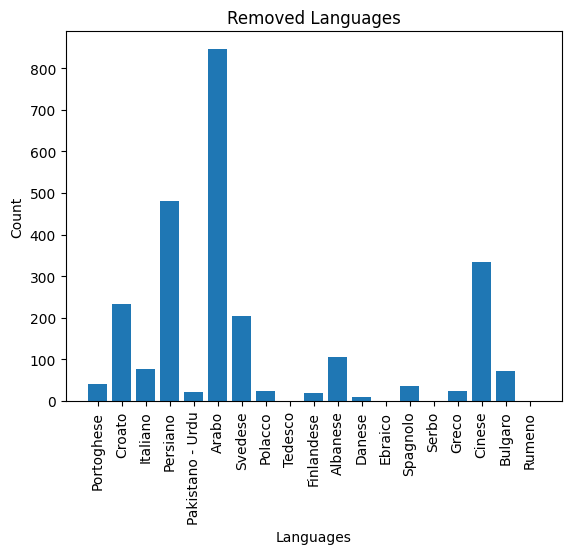

In [28]:
sums_age = results_df_age.iloc[:, 9:].sum()

f.plot_series(sums_age,'Removed Languages','Languages')

In [29]:
job_df_orig_age, job_df_repaired_age = f.compute_repaired_df(df_mitigation,11,protected_attribute_age)
job_df_orig_age['job_work_province_str'] = job_df_orig_age['job_work_province'].map(reversed_province_mapping)
job_df_repaired_age['job_work_province_str'] = job_df_repaired_age['job_work_province'].map(reversed_province_mapping)

job_df_orig_age['cand_domicile_region_str'] = job_df_orig_age['cand_domicile_region'].map(reversed_region_mapping)
job_df_repaired_age['cand_domicile_region_str'] = job_df_repaired_age['cand_domicile_region'].map(reversed_region_mapping)

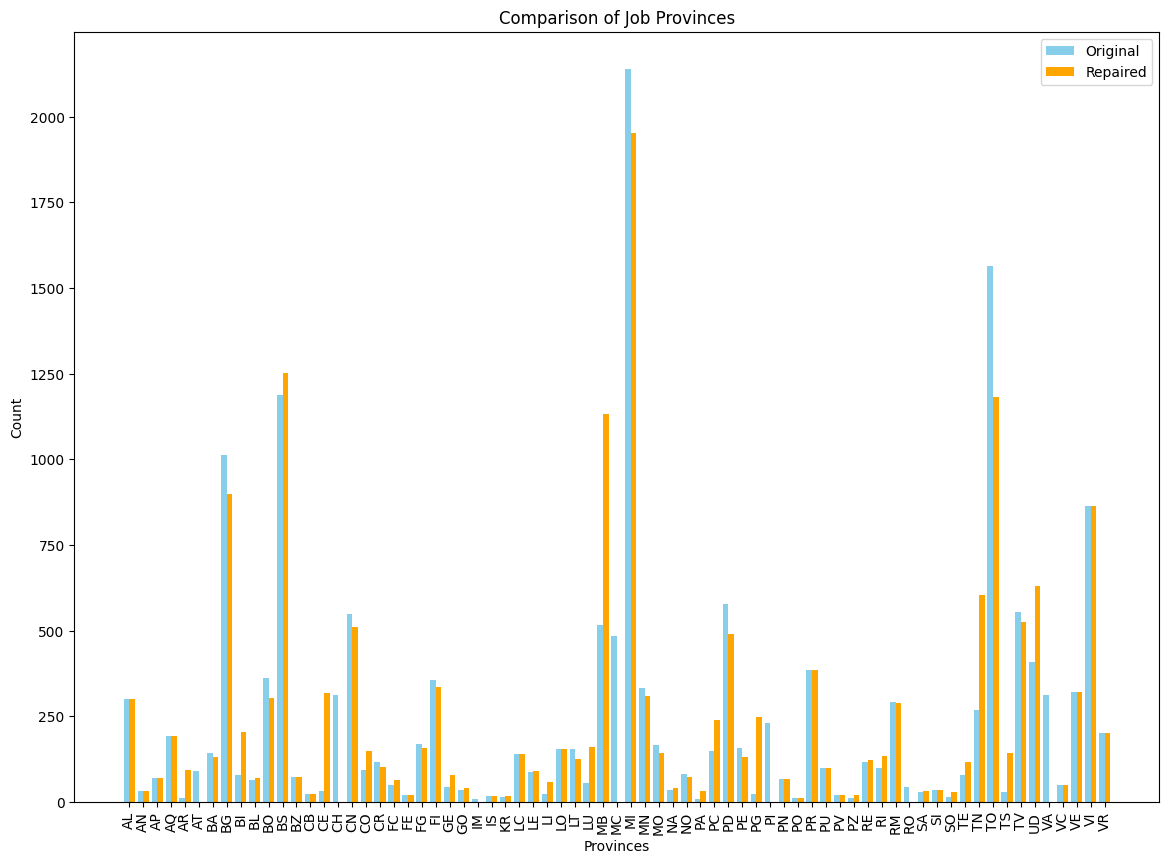

In [30]:
orig_counts = job_df_orig_age['job_work_province_str'].value_counts()
repaired_counts = job_df_repaired_age['job_work_province_str'].value_counts()

orig_counts,repaired_counts,all_index = f.prepare_different_series(orig_counts,repaired_counts)
f.compare_plot(orig_counts,repaired_counts,all_index,'Comparison of Job Provinces','Provinces',size=(14,10))

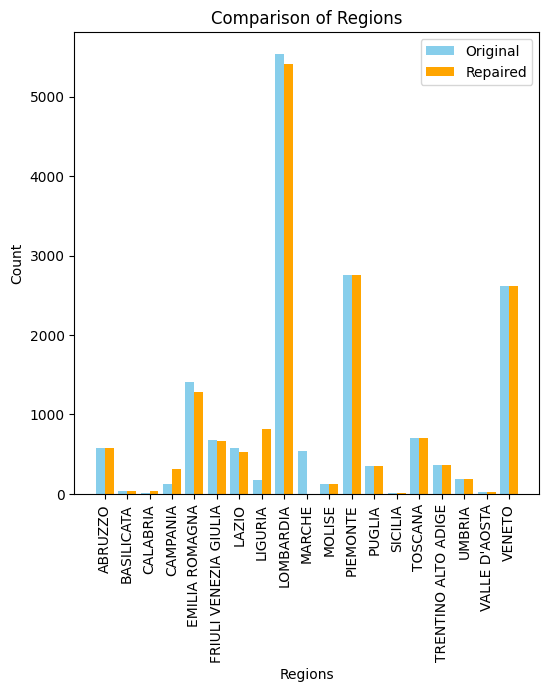

In [31]:
orig_counts = job_df_orig_age['cand_domicile_region_str'].value_counts()
repaired_counts = job_df_repaired_age['cand_domicile_region_str'].value_counts()

orig_counts,repaired_counts,all_index = f.prepare_different_series(orig_counts,repaired_counts)
f.compare_plot(orig_counts,repaired_counts,all_index,'Comparison of Regions','Regions')

## Location

In [32]:
protected_attribute_location = "same_location"
results_df_location = f.compute_bias_differences(df_mitigation,sectors,protected_attribute_location,columns)
results_df_location.to_excel('Results/Mitigation_reverse/results_df_location_reverse.xlsx', index=False)
results_df_location

d:\università\Magistrale\AI_industry\AEQUITAS-Debiasing-main\utils\functions.py:792: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, differences_df], ignore_index=True)


,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,job_contract_type,job_work_province,Norvegese,Catalano,Macedone,Portoghese,...,Albanese,Danese,Ebraico,Spagnolo,Serbo,Greco,Cinese,Bulgaro,Rumeno,same_location
0,0.0,0.0,9541.0,3382.0,0.0,3025.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,943.0,799.0,0.0,1531.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,3934.0,3250.0,0.0,3648.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,17764.0,91.0,0.0,2947.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,9130.0,1840.0,0.0,3797.0,0.0,0.0,0.0,1.0,...,0.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1593.0,177.0,0.0,1643.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0
6,0.0,0.0,2581.0,207.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,14744.0,3137.0,0.0,9294.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,15171.0,3578.0,0.0,424.0,0.0,5.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
9,0.0,0.0,30535.0,2996.0,0.0,15974.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


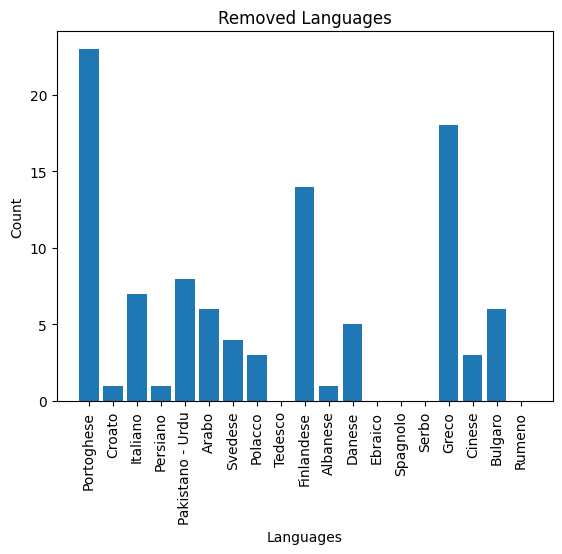

In [33]:
sums_location = results_df_location.iloc[:, 9:-1].sum()

f.plot_series(sums_location,'Removed Languages','Languages')

In [34]:
job_df_orig_location, job_df_repaired_location = f.compute_repaired_df(df_mitigation,7,protected_attribute_location)
job_df_orig_location['job_work_province_str'] = job_df_orig_location['job_work_province'].map(reversed_province_mapping)
job_df_repaired_location['job_work_province_str'] = job_df_repaired_location['job_work_province'].map(reversed_province_mapping)

job_df_orig_location['cand_domicile_province_str'] = job_df_orig_location['cand_domicile_province'].map(reversed_province_mapping)
job_df_repaired_location['cand_domicile_province_str'] = job_df_repaired_location['cand_domicile_province'].map(reversed_province_mapping)

job_df_orig_location['cand_domicile_region_str'] = job_df_orig_location['cand_domicile_region'].map(reversed_region_mapping)
job_df_repaired_location['cand_domicile_region_str'] = job_df_repaired_location['cand_domicile_region'].map(reversed_region_mapping)

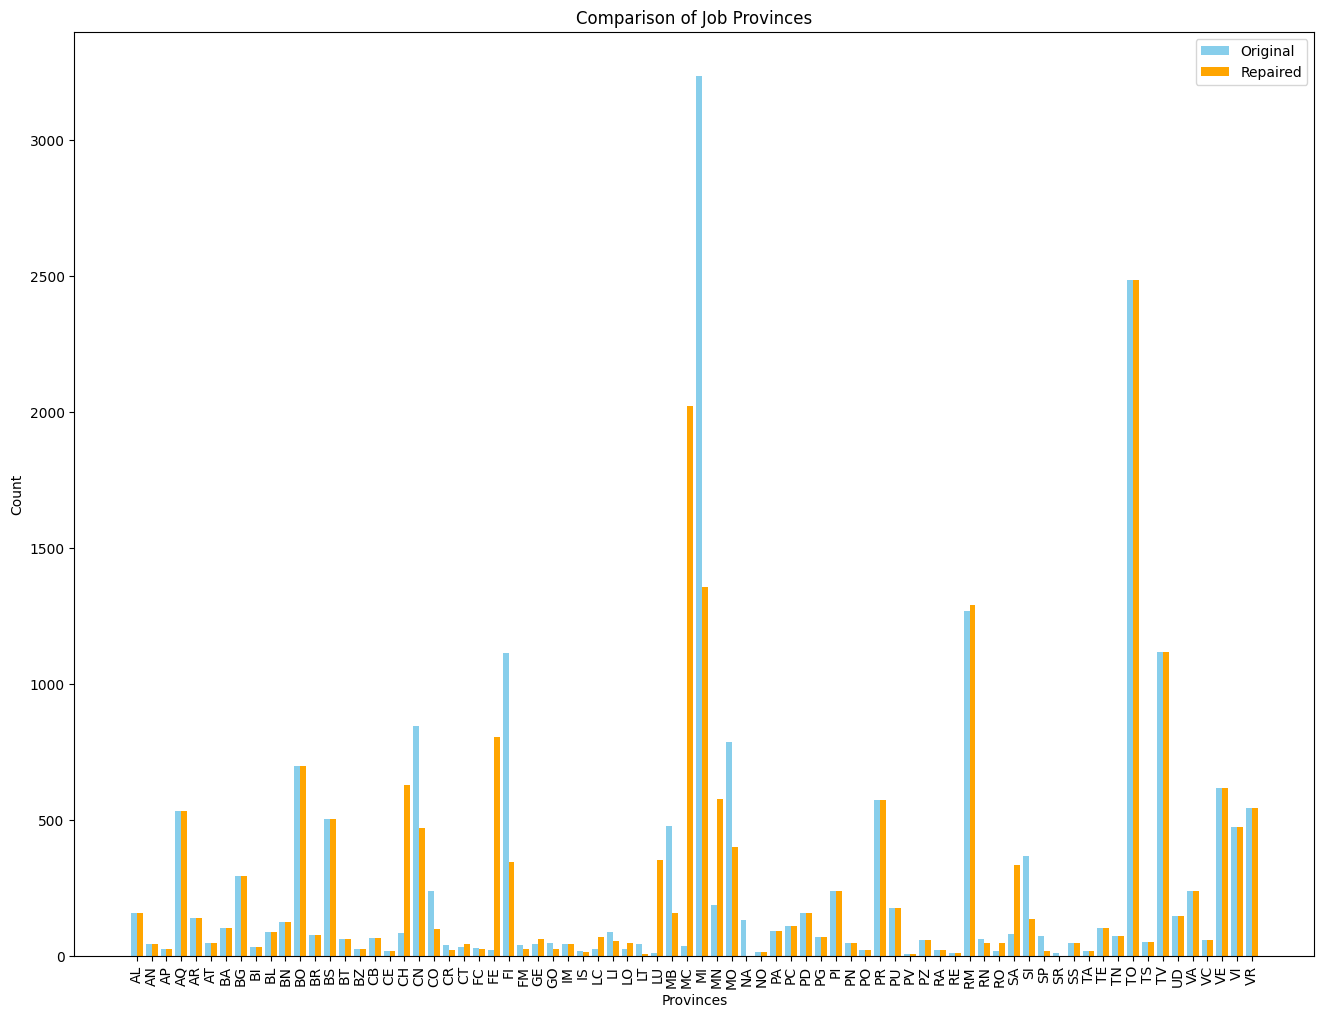

In [35]:
orig_counts = job_df_orig_location['job_work_province_str'].value_counts()
repaired_counts = job_df_repaired_location['job_work_province_str'].value_counts()

orig_counts,repaired_counts,all_index = f.prepare_different_series(orig_counts,repaired_counts)
f.compare_plot(orig_counts,repaired_counts,all_index,'Comparison of Job Provinces','Provinces',size=(16,12))

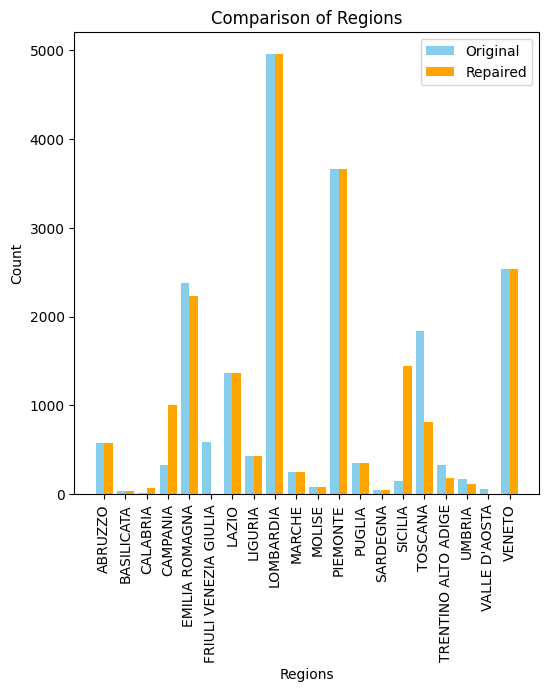

In [36]:
orig_counts = job_df_orig_location['cand_domicile_region_str'].value_counts()
repaired_counts = job_df_repaired_location['cand_domicile_region_str'].value_counts()

orig_counts,repaired_counts,all_index = f.prepare_different_series(orig_counts,repaired_counts)
f.compare_plot(orig_counts,repaired_counts,all_index,'Comparison of Regions','Regions')